## Лабораторная работа 3
### Метод сеток решения одномерного нестационарного уравнения теплопроводности

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

%matplotlib inline

Initial data

In [37]:
def get_k(x, k1=None, k2=None, k3=None):
    if k1 is None:
        return x
    elif k3 is None:
        if a <= x <= (b+a)*0.5:
            return k1
        return k2
    else:
        if a <= x <= (a + (b-a)/3):
            return k1
        elif (a + 2*(b-a)/3) < x <= b:
            return k3
        return k2

def f(x):
    return 1 / x

In [38]:
ua = ub = 3
a, b = 1, 2
h = (b-a) / 150
k2_matrix = [
    [1, 100], 
    [100, 1],
]
k3_matrix = [
    [1, 50, 200],         
    [200, 50, 1], 
    [20, 40, 20], 
    [200, 10, 200],
]

#### Задание 2

In [39]:
def get_a(x0, xn, *args):
    return integrate.quad(lambda x: 1 / get_k(x, *args), x0, xn)[0]**(-1)

def phi(x0, xn):
    return integrate.quad(f, x0, xn)[0]

In [335]:
def solve_static(a, b, ua, ub, sources=None, *args):
    n = int((b-a) / h) + 1
    x_vec = np.linspace(a, b, n)
    A = np.zeros((n, n))
    g = np.zeros((n, 1))
    A[0, 0] = A[-1, -1] = 1
    g[0] = ua
    g[-1] = ub

    for i in range(1, n - 1):
        A[i, i-1] = get_a(x_vec[i-1], x_vec[i], *args)
        A[i, i] = -get_a(x_vec[i-1], x_vec[i], *args) - get_a(x_vec[i], x_vec[i+1], *args)
        A[i, i+1] =  get_a(x_vec[i], x_vec[i+1], *args)
        if sources is None:
            g[i] = -phi(x_vec[i] - h/2, x_vec[i] + h/2)
        else:
            g[i] = -theta(x_vec[i], sources)
    return x_vec, np.linalg.solve(A, g)

def draw(x, y, label=None):
    plt.plot(x, y, label=label)
    plt.grid()
    if label is not None:
        plt.legend()
    plt.xlabel('x', size=14)
    plt.ylabel('u', size=14)
    plt.title('Conductivity')
    plt.show()

3.

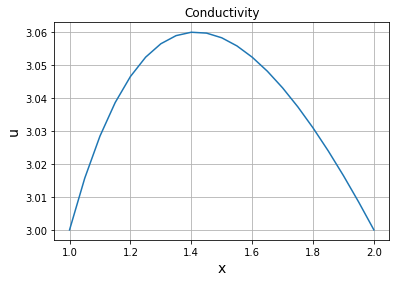

In [336]:
x, y = solve_static(a, b, ua, ub)
draw(x, y)

4.

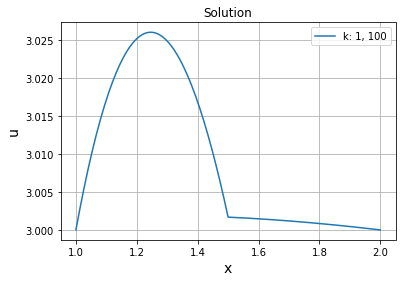

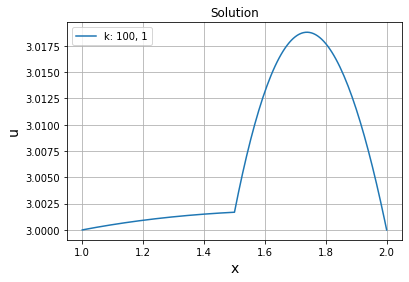

In [44]:
for k1, k2 in k2_matrix:
    x, y = solve_static(a, b, ua, ub, None, k1, k2)
    draw(x, y, f'k: {k1}, {k2}')

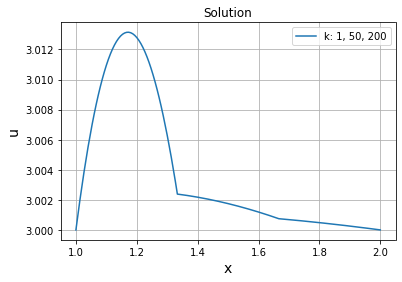

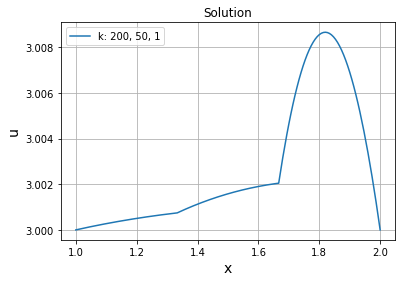

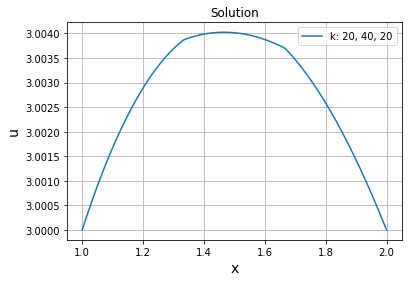

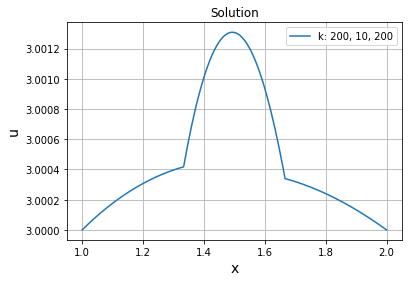

In [45]:
for k1, k2, k3 in k3_matrix:
    x, y = solve_static(a, b, ua, ub, None, k1, k2, k3)
    draw(x, y, f'k: {k1}, {k2}, {k3}')

5.

In [46]:
def delta(x, x0, c):
    if (abs(x - x0) - h / 2) < 1e-6:
        return c / 2
    elif abs(x - x0) < h/2:
        return c
    return 0

def theta(x, sources):
    return sum(delta(x, x0, ci) for ci, x0 in sources)

In [47]:
sources = [
    [(10, a + (b - a) / 2)],
    [(20, a + (b - a) / 4), (20, a + 3 * (b - a) / 4)],
    [(10, a + (b - a) / 4), (50, a + 3 * (b - a) / 4)],
]

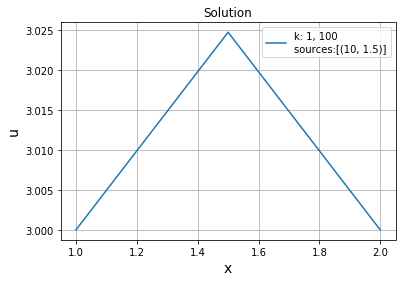

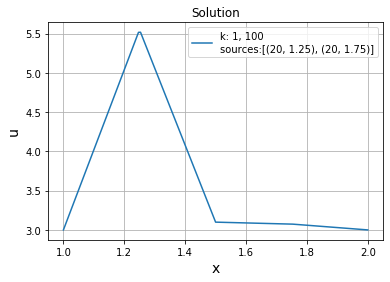

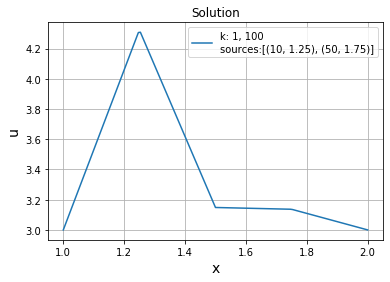

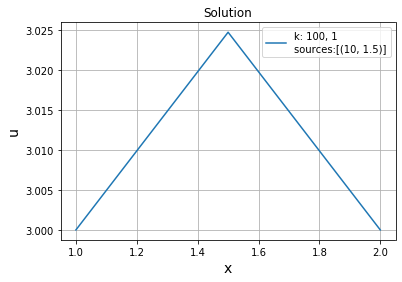

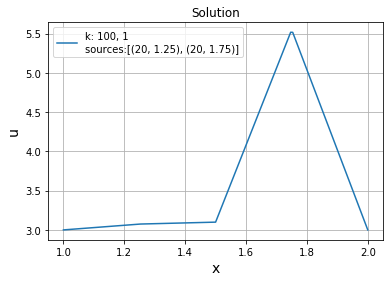

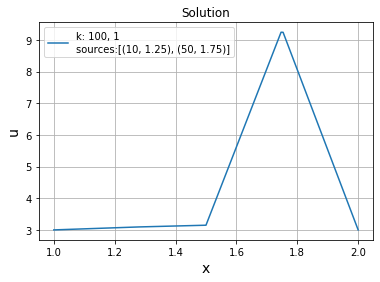

In [48]:
for k1, k2 in k2_matrix:
    for src in sources:
        x, y = solve_static(a, b, ua, ub, src, k1, k2)
        draw(x, y, f'k: {k1}, {k2}\nsources:{src}')

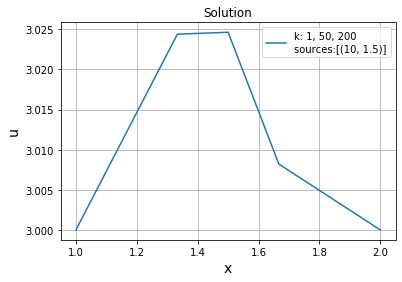

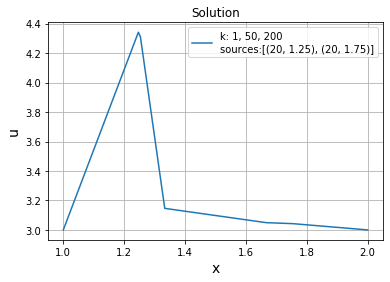

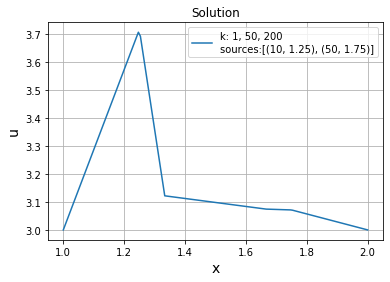

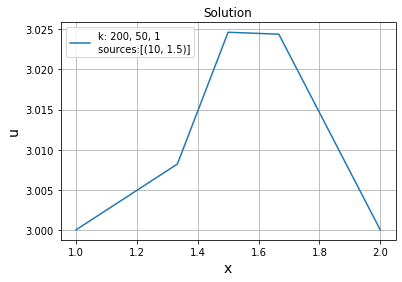

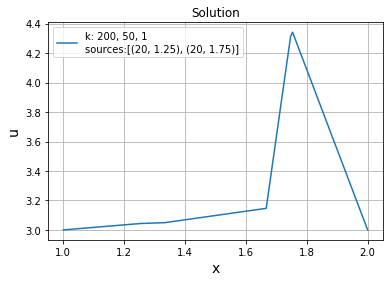

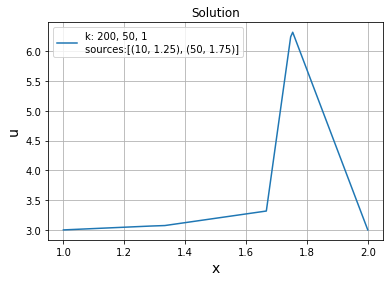

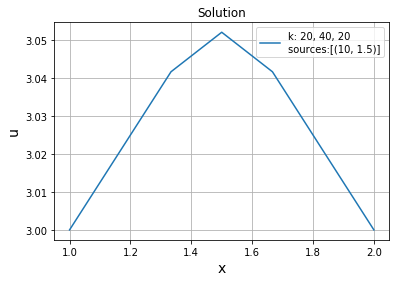

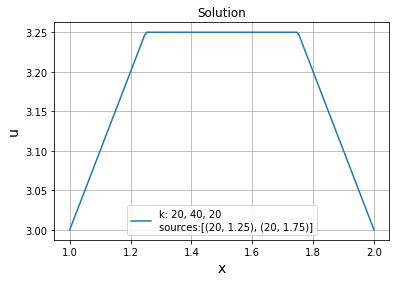

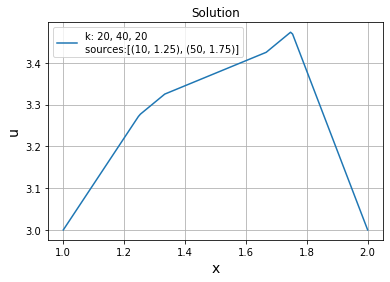

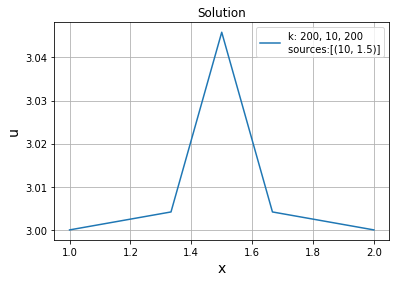

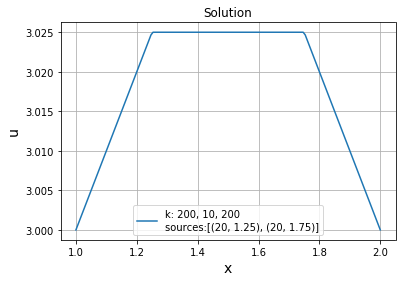

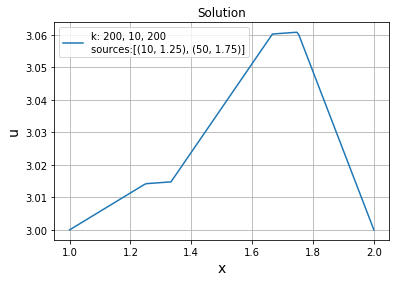

In [49]:
for k1, k2, k3 in k3_matrix:
    for src in sources:
        x, y = solve_static(a, b, ua, ub, src, k1, k2, k3)
        draw(x, y, f'k: {k1}, {k2}, {k3}\nsources:{src}')

#### Задание 3

In [15]:
def solve_nonstatic(a, b, ua, ub, k, f, phi, T, h=0.01, dt=0.05):
    nt = int(T/dt) + 1
    nx = int((b-a) / h) + 1
    x_vec = np.linspace(a, b, nx)
    t_vec = np.linspace(0, T, nt)
    A = np.zeros((nt, nx))
    A[0] = [phi(x) for x in x_vec]
    A[:, 0] = ua
    A[:, -1] = ub

    for i in range(nt - 1):
        for j in range(1, nx - 1):            
            A[i + 1, j] = (dt/(4*h**2) * (4*k(x_vec[j]) - k(x_vec[j] + h) + k(x_vec[j] - h)) * A[i, j-1] 
                           + (1 - 2*k(x_vec[j])*dt/h**2) * A[i, j]
                           + dt/(4*h**2) * (k(x_vec[j] + h) - k(x_vec[j] - h) + 4*k(x_vec[j])) * A[i, j+1]
                           + dt*f(x_vec[j]) * (1-np.exp(-t_vec[i])))
    return x_vec, t_vec, A
    
    
def draw(x, y, xl=None, yl=None, label=None):
    plt.plot(x, y, label=label)
    if label is not None:
        plt.legend()
    plt.xlabel(xl, size=14)
    plt.ylabel(yl, size=14)
    plt.title('Conductivity')
    return plt

In [16]:
a, b = 1, 2
ua = ub = 3
dt = 0.0001
h = 0.05
T = 400*dt
t_show = [0, 5, 20, 200]
x_row, t_row, A = solve_nonstatic(a, b, ua, ub, lambda x: x, lambda x: 1/x, lambda x: x**2, T, h, dt)

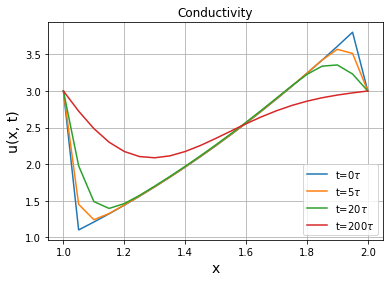

In [17]:
for i in t_show:
    draw(x_row, A[i], 'x', 'u(x, t)', fr't={i}$\tau$')
plt.grid()
plt.show()

смещение к x~1.6

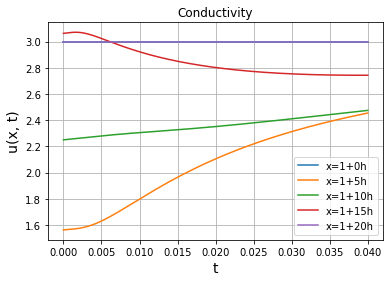

In [5]:
for j in range(0, int((b-a)/h)+1, 5):
    draw(t_row, A[:, j], 't', 'u(x, t)', f'x={a}+{j}h')
plt.grid()
plt.show()

температура стремится к ~2.5

#### Задание 4

In [9]:
def solve_nonstatic2(a, b, h, dt, k, T, g1, g2, f, phi):
    nt = int(T/dt) + 1
    nx = int((b-a) / h) + 1
    x_vec = np.linspace(a, b, nx)
    t_vec = np.linspace(0, T, nt)
    A = np.zeros((nt, nx))
    A[0] = [phi(x) for x in x_vec]
    A[:, 0] = [g1(t) for t in t_vec]
    A[:, -1] = [g2(t) for t in t_vec]

    for i in range(nt - 1):
        for j in range(1, nx - 1):            
            A[i + 1, j] = (k*dt/h**2*A[i, j-1] + (1-2*k*dt/h**2)*A[i, j] 
                           + k*dt/h**2*A[i, j+1] + dt*f(x_vec[j], t_vec[i]))
    return x_vec, t_vec, A
    
    
def draw(x, y, xl=None, yl=None, label=None):
    plt.plot(x, y, label=label)
    if label is not None:
        plt.legend()
    plt.xlabel(xl, size=14)
    plt.ylabel(yl, size=14)
    plt.title('Conductivity')
    return plt

In [31]:
a, b = -1, 1
h = (b-a) / 10
k = 0.5
dt = 0.5*h**2/k   # stability condition
T = 0.4
x_row, t_row, A = solve_nonstatic2(a, b, h, dt, k, T, lambda x: 1, lambda x: 1, lambda x,t: x, lambda x: x**2)

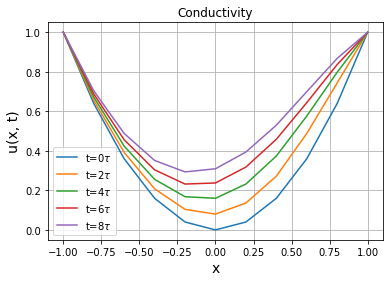

In [32]:
for i in range(0, int(T/dt)+1, 2):
    draw(x_row, A[i], 'x', 'u(x, t)', fr't={i}$\tau$')
plt.grid()
plt.show()